C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

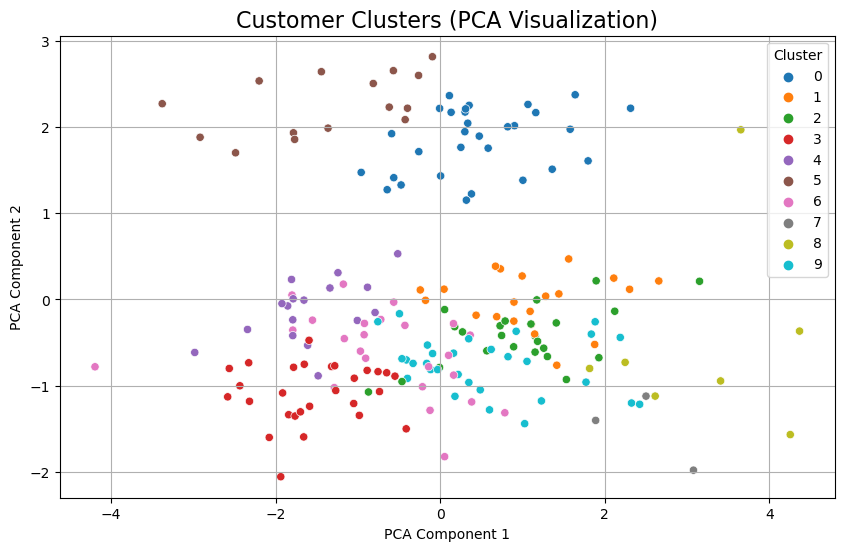

Optimal Number of Clusters: 10
DB Index for Optimal Clusters: 1.01553231585756


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('C:\\Users\\KIIT\\Downloads\\Customers.csv')
transactions = pd.read_csv('C:\\Users\\KIIT\\Downloads\\Transactions.csv')

# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID')

# Feature Engineering
customer_features = merged_data.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    TransactionFrequency=('TransactionID', 'count'),
    AvgTransactionValue=('TotalValue', 'mean'),
    TimeSinceSignup=('TransactionDate', lambda x: (pd.to_datetime('2025-01-01') - pd.to_datetime(x.min())).days)
).reset_index()

# Add region as a feature (one-hot encoding)
region_dummies = pd.get_dummies(customers.set_index('CustomerID')['Region'], prefix='Region')
customer_features = customer_features.merge(region_dummies, left_on='CustomerID', right_index=True)

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))

# Determine the optimal number of clusters using DB Index
db_scores = []
for k in range(2, 11):  # Test cluster sizes from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(normalized_features)
    db_index = davies_bouldin_score(normalized_features, labels)
    db_scores.append((k, db_index))

# Find the optimal number of clusters (lowest DB Index)
optimal_clusters = min(db_scores, key=lambda x: x[1])[0]

# Fit K-Means with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(normalized_features)

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(normalized_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_features['Cluster'], palette='tab10')
plt.title('Customer Clusters (PCA Visualization)', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Save results
customer_features.to_csv('Sarthak_Prusty_Clustering.csv', index=False)

# Print results
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"DB Index for Optimal Clusters: {min(db_scores, key=lambda x: x[1])[1]}")
